**Kaggle competition : Titanic**

# Introduction

Objective: Predict survival of passengers on the Titanic

# Imports (datasets and lib)

In [13]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, roc_auc_score, make_scorer
from sklearn.svm import SVC
from xgboost import XGBClassifier
import time
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from scipy.stats import pointbiserialr, chi2_contingency

In [14]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [15]:
titanic_path = '/kaggle/input/titanic/'
os.listdir(titanic_path)

['train.csv', 'test.csv', 'gender_submission.csv']

# Exploratory Data Analysis (EDA)

In [16]:
train_df = pd.read_csv(os.path.join(titanic_path, 'train.csv'))
test_df = pd.read_csv(os.path.join(titanic_path, 'test.csv'))
submit_df = pd.read_csv(os.path.join(titanic_path, 'gender_submission.csv'))

In [17]:
# Configuration d'affichage
pd.set_option('display.max_columns', None)
sns.set(style='whitegrid')

## Overview of the data (shape, info, preview)

In [18]:
print("Shape of train dataset:", train_df.shape)

Shape of train dataset: (891, 12)


In [19]:
print("Shape of test dataset:", test_df.shape)

Shape of test dataset: (418, 11)


In [20]:
display(train_df.head())

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [21]:
display(test_df.head())

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [22]:
display(submit_df.head())

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [23]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [24]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## Missing values analysis

In [25]:
missing_values = train_df.isnull().sum()
print("Missing values:\n", missing_values[missing_values > 0])

Missing values:
 Age         177
Cabin       687
Embarked      2
dtype: int64


In [26]:
missing_values = test_df.isnull().sum()
print("Missing values:\n", missing_values[missing_values > 0])

Missing values:
 Age       86
Fare       1
Cabin    327
dtype: int64


## Distribution of target variable

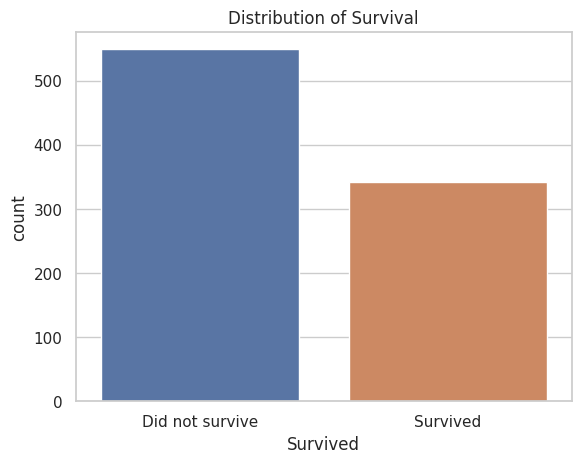

In [27]:
sns.countplot(x='Survived', data=train_df)
plt.title('Distribution of Survival')
plt.xticks([0, 1], ['Did not survive', 'Survived'])
plt.show()

## Univariate analysis (Age, Sex, Pclass, etc.)

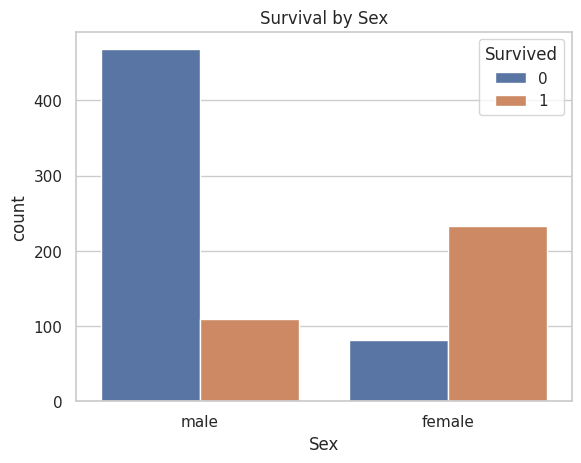

In [28]:
# Répartition selon le sexe
sns.countplot(x='Sex', hue='Survived', data=train_df)
plt.title('Survival by Sex')
plt.show()

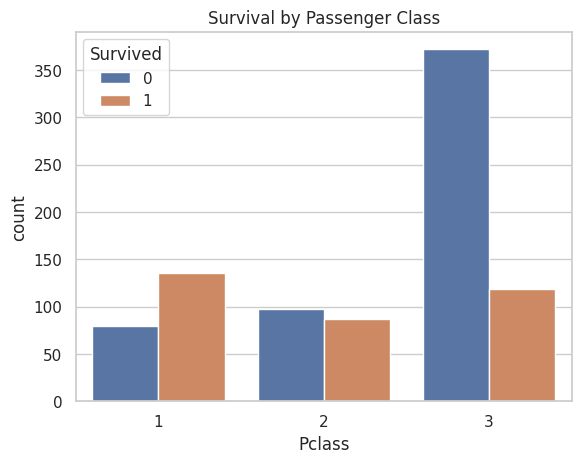

In [29]:
# Répartition selon la classe
sns.countplot(x='Pclass', hue='Survived', data=train_df)
plt.title('Survival by Passenger Class')
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


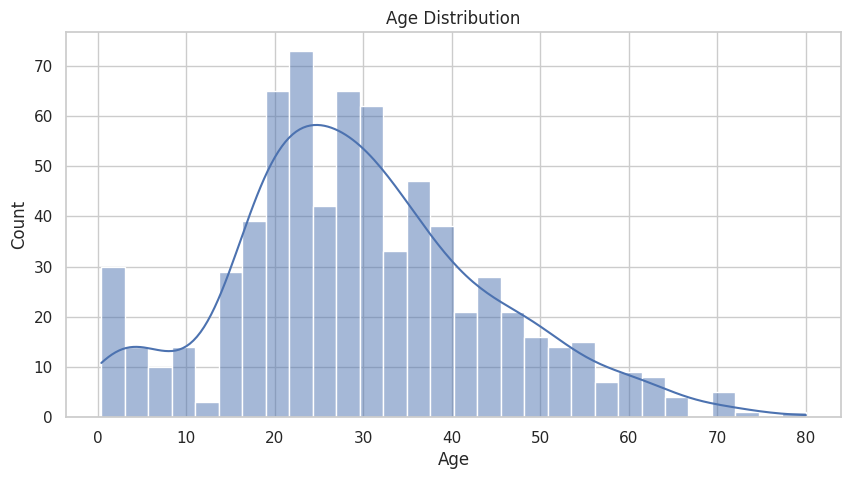

In [30]:
# Distribution de l’âge
plt.figure(figsize=(10,5))
sns.histplot(train_df['Age'].dropna(), bins=30, kde=True)
plt.title('Age Distribution')
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


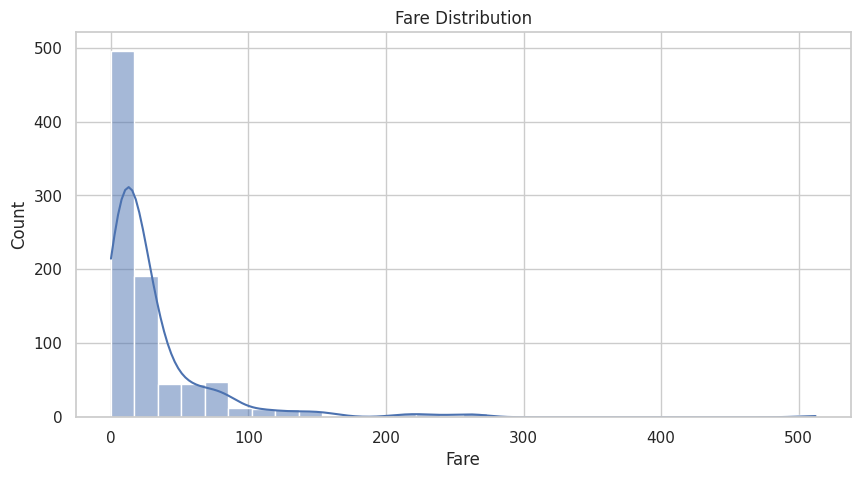

In [31]:
# Distribution de l’âge
plt.figure(figsize=(10,5))
sns.histplot(train_df['Fare'].dropna(), bins=30, kde=True)
plt.title('Fare Distribution')
plt.show()

## Bivariate analysis

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


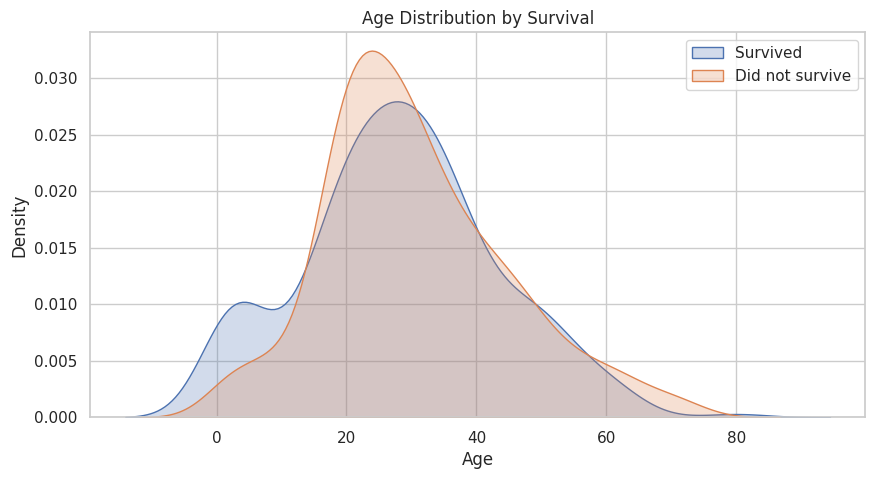

In [32]:
# Âge et survie
plt.figure(figsize=(10,5))
sns.kdeplot(data=train_df[train_df['Survived'] == 1]['Age'].dropna(), label='Survived', fill=True)
sns.kdeplot(data=train_df[train_df['Survived'] == 0]['Age'].dropna(), label='Did not survive', fill=True)
plt.title('Age Distribution by Survival')
plt.legend()
plt.show()

# Data Cleaning & Preprocessing

### Title extraction

In [33]:
# Extraction du titre avec regex
train_df['Title'] = train_df['Name'].str.extract(r',\s*([^\.]+)\.', expand=False)
test_df['Title'] = test_df['Name'].str.extract(r',\s*([^\.]+)\.', expand=False)


In [34]:
print("Titres dans train set :", train_df['Title'].unique())
print("Titres dans test set  :", test_df['Title'].unique())


Titres dans train set : ['Mr' 'Mrs' 'Miss' 'Master' 'Don' 'Rev' 'Dr' 'Mme' 'Ms' 'Major' 'Lady'
 'Sir' 'Mlle' 'Col' 'Capt' 'the Countess' 'Jonkheer']
Titres dans test set  : ['Mr' 'Mrs' 'Miss' 'Master' 'Ms' 'Col' 'Rev' 'Dr' 'Dona']


In [35]:
title_mapping = {
    'Mr': 'Mr',
    'Mrs': 'Mrs', 'Mme': 'Mrs',
    'Miss': 'Miss', 'Mlle': 'Miss', 'Ms': 'Miss',
    'Master': 'Master',
    'Don': 'Rare', 'Sir': 'Rare', 'Lady': 'Rare', 'Dona': 'Rare', 'Jonkheer': 'Rare', 'the Countess': 'Rare',
    'Capt': 'Officer', 'Col': 'Officer', 'Major': 'Officer',
    'Dr': 'Professional', 'Rev': 'Professional'
}

# Application à train et test
train_df['Title_grouped'] = train_df['Title'].map(title_mapping)
test_df['Title_grouped'] = test_df['Title'].map(title_mapping)


In [36]:
print(train_df['Title_grouped'].value_counts())


Title_grouped
Mr              517
Miss            185
Mrs             126
Master           40
Professional     13
Rare              5
Officer           5
Name: count, dtype: int64


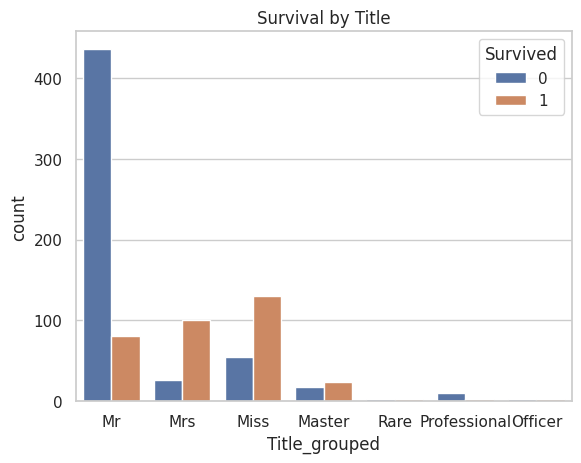

In [37]:
# Répartition selon la classe
sns.countplot(x='Title_grouped', hue='Survived', data=train_df)
plt.title('Survival by Title')
plt.show()

## Handling missing values

In [38]:
# Age missing values completed with KNN

# One-hot encoding du Title_grouped
title_dummies_train = pd.get_dummies(train_df['Title_grouped'], prefix='Title')
title_dummies_test = pd.get_dummies(test_df['Title_grouped'], prefix='Title')

# Alignement des colonnes entre train et test
title_dummies_test = title_dummies_test.reindex(columns=title_dummies_train.columns, fill_value=0)

# Intégration définitive dans train_df et test_df
train_df = pd.concat([train_df, title_dummies_train], axis=1)
test_df = pd.concat([test_df, title_dummies_test], axis=1)

# Variables à utiliser pour l’imputation d’Age
features_for_age = ['Age', 'Fare', 'Parch', 'SibSp', 'Pclass'] + list(title_dummies_train.columns)

# KNN Imputer
imputer = KNNImputer(n_neighbors=5)

# Train
age_train = train_df[features_for_age]
train_df['Age'] = imputer.fit_transform(age_train)[:, 0]

# Test
age_test = test_df[features_for_age]
test_df['Age'] = imputer.transform(age_test)[:, 0]


In [39]:
# Extraction of deck
# Train
train_df['Cabin'] = train_df['Cabin'].fillna('Unknown')
train_df['Deck'] = train_df['Cabin'].apply(lambda x: x[0] if x != 'Unknown' else 'U')

# Test
test_df['Cabin'] = test_df['Cabin'].fillna('Unknown')
test_df['Deck'] = test_df['Cabin'].apply(lambda x: x[0] if x != 'Unknown' else 'U')

In [40]:
# mode imputation for embarked missing values
train_df['Embarked'] = train_df['Embarked'].fillna(train_df['Embarked'].mode()[0])
# Test
test_df['Embarked'] = test_df['Embarked'].fillna(train_df['Embarked'].mode()[0])

In [41]:
# median imputation
test_df['Fare'] = test_df['Fare'].fillna(train_df['Fare'].median())

## Feature encoding

In [42]:
#  Encodage de Sex (label)
le_sex = LabelEncoder()
train_df['Sex_encoded'] = le_sex.fit_transform(train_df['Sex'])
test_df['Sex_encoded'] = le_sex.transform(test_df['Sex'])

In [43]:
# Encodage de Embarked (label)
le_embarked = LabelEncoder()
train_df['Embarked_encoded'] = le_embarked.fit_transform(train_df['Embarked'])
test_df['Embarked_encoded'] = le_embarked.transform(test_df['Embarked'])

In [44]:
# Encodage de Deck (OH)
train_df = pd.get_dummies(train_df, columns=['Deck'], prefix='Deck')
test_df = pd.get_dummies(test_df, columns=['Deck'], prefix='Deck')

# Aligner les colonnes (pour éviter que le test manque une modalité rare)
missing_cols = set(train_df.columns) - set(test_df.columns)
for col in missing_cols:
    if 'Deck_' in col:
        test_df[col] = 0

## Feature engineering

### Ticket prefix

In [45]:
# 🧠 Fonction pour extraire le préfixe d'un ticket
def extract_ticket_prefix(ticket):
    ticket = ticket.replace('.', '').replace('/', '').strip().upper()
    parts = ticket.split()
    return parts[0] if not parts[0].isdigit() else 'NUMERIC'

In [46]:
# Création de la nouvelle colonne
train_df['TicketPrefix'] = train_df['Ticket'].apply(extract_ticket_prefix)
test_df['TicketPrefix'] = test_df['Ticket'].apply(extract_ticket_prefix)

In [47]:
# Vérification rapide de la distribution
print("Top prefixes (train):")
print(train_df['TicketPrefix'].value_counts().head())

Top prefixes (train):
TicketPrefix
NUMERIC    661
PC          60
CA          41
A5          21
SOTONOQ     15
Name: count, dtype: int64


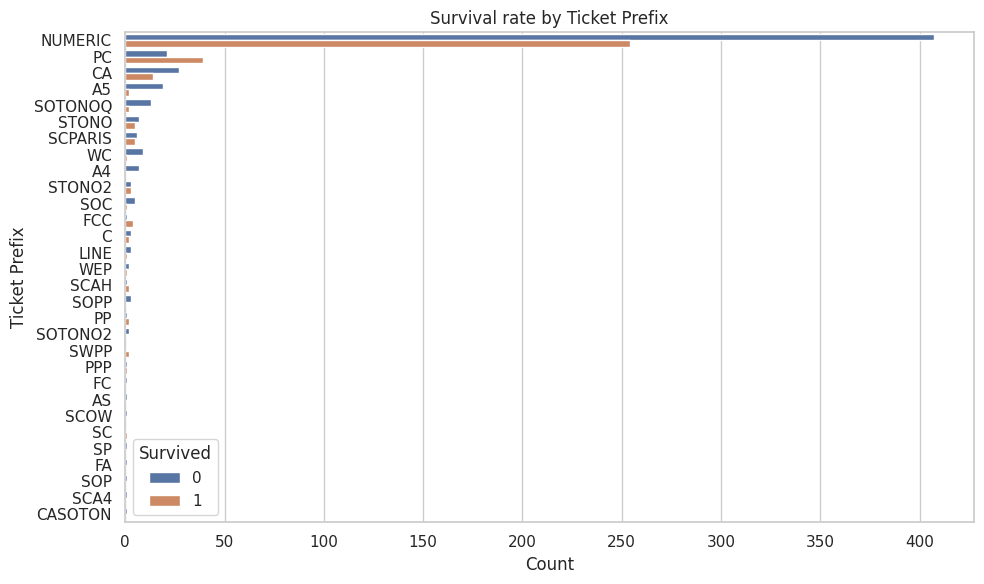

In [48]:
# Visualisation : survie selon le préfixe
plt.figure(figsize=(10,6))
sns.countplot(y='TicketPrefix', hue='Survived',
              data=train_df, order=train_df['TicketPrefix'].value_counts().index)
plt.title('Survival rate by Ticket Prefix')
plt.xlabel('Count')
plt.ylabel('Ticket Prefix')
plt.legend(title='Survived')
plt.tight_layout()
plt.show()

In [49]:
def group_ticket_prefix(prefix):
    prefix = prefix.upper()  # au cas où
    if prefix in ['PC', 'FCC', 'SOC', 'WEP', 'PP', 'PPP']:
        return 'FirstClass_Agency'
    elif prefix.startswith(('STON', 'SOTONO', 'SC', 'SOP', 'SWPP', 'S.O.')):
        return 'Emigrant_Tickets'
    elif prefix.startswith(('A/5', 'A/4', 'C.A.', 'C ', 'S.P.', 'S.P')):
        return 'ThirdClass_Eco'
    elif prefix.startswith(('CA', 'FA', 'FC', 'WC')):
        return 'Cabin_Label'
    elif prefix == 'NUMERIC':
        return 'Numeric'
    else:
        return 'RARE'

In [50]:
train_df['TicketPrefix_grouped'] = train_df['TicketPrefix'].apply(group_ticket_prefix)
test_df['TicketPrefix_grouped'] = test_df['TicketPrefix'].apply(group_ticket_prefix)

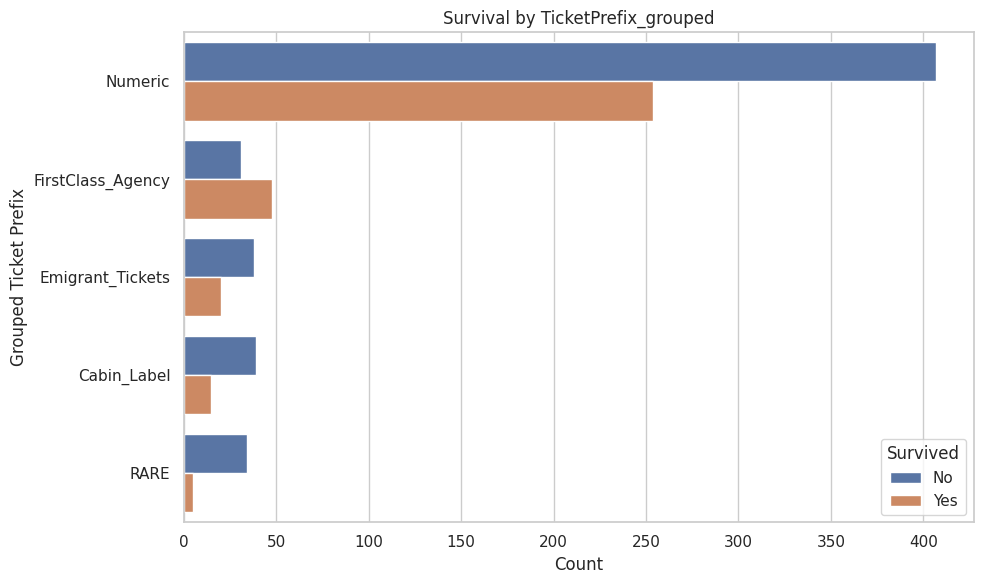

In [51]:
# visualisation
plt.figure(figsize=(10,6))
sns.countplot(data=train_df, y='TicketPrefix_grouped', hue='Survived', order=train_df['TicketPrefix_grouped'].value_counts().index)
plt.title('Survival by TicketPrefix_grouped')
plt.xlabel('Count')
plt.ylabel('Grouped Ticket Prefix')
plt.legend(title='Survived', labels=['No', 'Yes'])
plt.tight_layout()
plt.show()

In [52]:
# Encodage
train_df = pd.get_dummies(train_df, columns=['TicketPrefix_grouped'], prefix='TPG')
test_df = pd.get_dummies(test_df, columns=['TicketPrefix_grouped'], prefix='TPG')

# Pour éviter les colonnes manquantes dans le test set :
missing_cols = set(train_df.columns) - set(test_df.columns)
for col in missing_cols:
    if 'TPG_' in col:
        test_df[col] = 0

### Fare per person and class

In [53]:
# Nombre de passagers par ticket
ticket_group_size = train_df['Ticket'].map(train_df['Ticket'].value_counts())
ticket_group_size_test = test_df['Ticket'].map(test_df['Ticket'].value_counts())

In [54]:
# Fare par personne
train_df['Fare_per_person'] = train_df['Fare'] / ticket_group_size
test_df['Fare_per_person'] = test_df['Fare'] / ticket_group_size_test

In [55]:
# Moyenne et std de Fare_per_person par classe dans le TRAIN
fare_stats_by_class = train_df.groupby('Pclass')['Fare_per_person'].agg(['mean', 'std'])


# Fonction d'application avec fallback sur std > 0
def compute_relative_fare(row):
    pclass = row['Pclass']
    fpp = row['Fare_per_person']
    mean = fare_stats_by_class.loc[pclass, 'mean']
    std = fare_stats_by_class.loc[pclass, 'std']
    return (fpp - mean) / std if std > 0 else 0


train_df['RelativeFare'] = train_df.apply(compute_relative_fare, axis=1)
test_df['RelativeFare'] = test_df.apply(compute_relative_fare, axis=1)

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


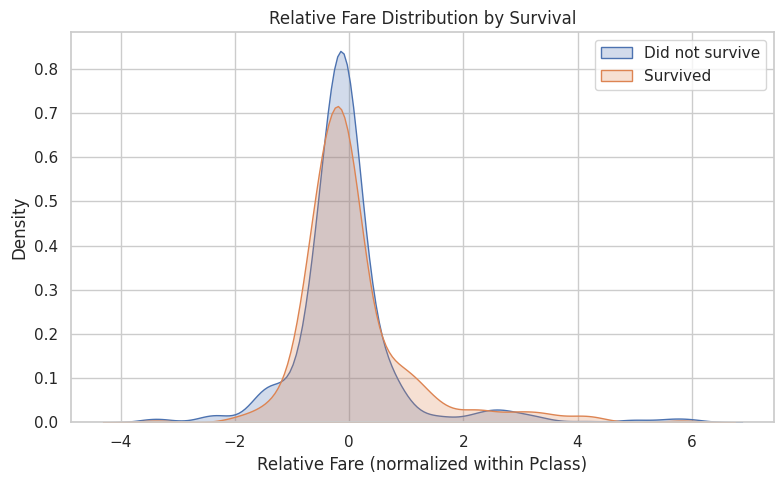

In [56]:
plt.figure(figsize=(8, 5))
sns.kdeplot(data=train_df[train_df['Survived'] == 0]['RelativeFare'], label='Did not survive', fill=True)
sns.kdeplot(data=train_df[train_df['Survived'] == 1]['RelativeFare'], label='Survived', fill=True)
plt.title('Relative Fare Distribution by Survival')
plt.xlabel('Relative Fare (normalized within Pclass)')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()


### FamilySize

In [57]:
train_df['FamilySize'] = train_df['SibSp'] + train_df['Parch'] + 1
test_df['FamilySize'] = test_df['SibSp'] + test_df['Parch'] + 1

### IsAlone

In [58]:
train_df['IsAlone'] = (train_df['FamilySize'] == 1).astype(int)
test_df['IsAlone'] = (test_df['FamilySize'] == 1).astype(int)

### Age * Pclass, Age * Fare

In [59]:
train_df['Age_Pclass'] = train_df['Age'] * train_df['Pclass']
test_df['Age_Pclass'] = test_df['Age'] * test_df['Pclass']

In [60]:
train_df['Age_Fare'] = train_df['Age'] * train_df['Fare']
test_df['Age_Fare'] = test_df['Age'] * test_df['Fare']

### Fare_bin, Age_bin – Discrétisation

In [61]:
train_df['Fare_bin'] = pd.qcut(train_df['Fare'], 4, labels=False)
train_df['Age_bin'] = pd.cut(train_df['Age'], bins=[0, 12, 18, 35, 60, 100], labels=False)

test_df['Fare_bin'] = pd.qcut(test_df['Fare'], 4, labels=False)
test_df['Age_bin'] = pd.cut(test_df['Age'], bins=[0, 12, 18, 35, 60, 100], labels=False)


### Title_FamilySize – Croisement fin

In [62]:
#train_df['Title_FamilySize'] = train_df['FamilySize'].astype(str) + '_' + train_df['Title_grouped']
#test_df['Title_FamilySize'] = test_df['FamilySize'].astype(str) + '_' + test_df['Title_grouped']

## Feature scaling

In [63]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Title_grouped,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Professional,Title_Rare,Sex_encoded,Embarked_encoded,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Deck_U,TicketPrefix,TPG_Cabin_Label,TPG_Emigrant_Tickets,TPG_FirstClass_Agency,TPG_Numeric,TPG_RARE,Fare_per_person,RelativeFare,FamilySize,IsAlone,Age_Pclass,Age_Fare,Fare_bin,Age_bin
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,Unknown,S,Mr,Mr,False,False,True,False,False,False,False,1,2,False,False,False,False,False,False,False,False,True,A5,False,False,False,False,True,7.2500,-0.349158,2,0,66.0,159.5000,0,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,Mrs,False,False,False,True,False,False,False,0,0,False,False,True,False,False,False,False,False,False,PC,False,False,True,False,False,71.2833,0.911310,2,0,38.0,2708.7654,3,3
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,Unknown,S,Miss,Miss,False,True,False,False,False,False,False,0,2,False,False,False,False,False,False,False,False,True,STONO2,False,True,False,False,False,7.9250,-0.067194,1,1,78.0,206.0500,1,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,Mrs,False,False,False,True,False,False,False,0,2,False,False,True,False,False,False,False,False,False,NUMERIC,False,False,False,True,False,26.5500,-0.563954,2,0,35.0,1858.5000,3,2
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,Unknown,S,Mr,Mr,False,False,True,False,False,False,False,1,2,False,False,False,False,False,False,False,False,True,NUMERIC,False,False,False,True,False,8.0500,-0.014978,1,1,105.0,281.7500,1,2


In [64]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_encoded,Embarked_encoded,Fare_per_person,RelativeFare,FamilySize,IsAlone,Age_Pclass,Age_Fare,Fare_bin,Age_bin
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,8.910000e+02,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,30.016393,0.523008,0.381594,32.204208,0.647587,1.536476,17.788989,4.585433e-17,1.904602,0.602694,65.070572,1031.877275,1.497194,2.069585
std,257.353842,0.486592,0.836071,13.533892,1.102743,0.806057,49.693429,0.477990,0.791503,21.218157,9.988758e-01,1.613459,0.489615,33.261426,1816.745218,1.118156,0.875179
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-3.377660e+00,1.000000,0.000000,0.920000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400,0.000000,1.000000,7.762500,-4.327027e-01,1.000000,0.000000,42.000000,205.645000,0.500000,2.000000
50%,446.000000,0.000000,3.000000,29.000000,0.000000,0.000000,14.454200,1.000000,2.000000,8.850000,-9.982859e-02,1.000000,1.000000,62.000000,351.000000,1.000000,2.000000
75%,668.500000,1.000000,3.000000,37.500000,1.000000,0.000000,31.000000,1.000000,2.000000,24.288200,3.795912e-02,2.000000,1.000000,84.750000,1136.097500,2.000000,3.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,1.000000,2.000000,221.779200,6.031583e+00,11.000000,1.000000,222.000000,18443.851200,3.000000,4.000000


In [65]:
# log transformation pour Fare (+1 pour eviter le log 0)
train_df['Fare'] = np.log1p(train_df['Fare'])
test_df['Fare'] = np.log1p(test_df['Fare'])

In [66]:
# Variables à scaler
features_to_scale = ['Age', 'Fare', 'SibSp', 'Parch', 'Fare_per_person', 'FamilySize', 'Age_Pclass', 'Age_Fare']

scaler = StandardScaler()

train_df[features_to_scale] = scaler.fit_transform(train_df[features_to_scale])
test_df[features_to_scale] = scaler.transform(test_df[features_to_scale])

# Feature Selection

## Correlation matrix

/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


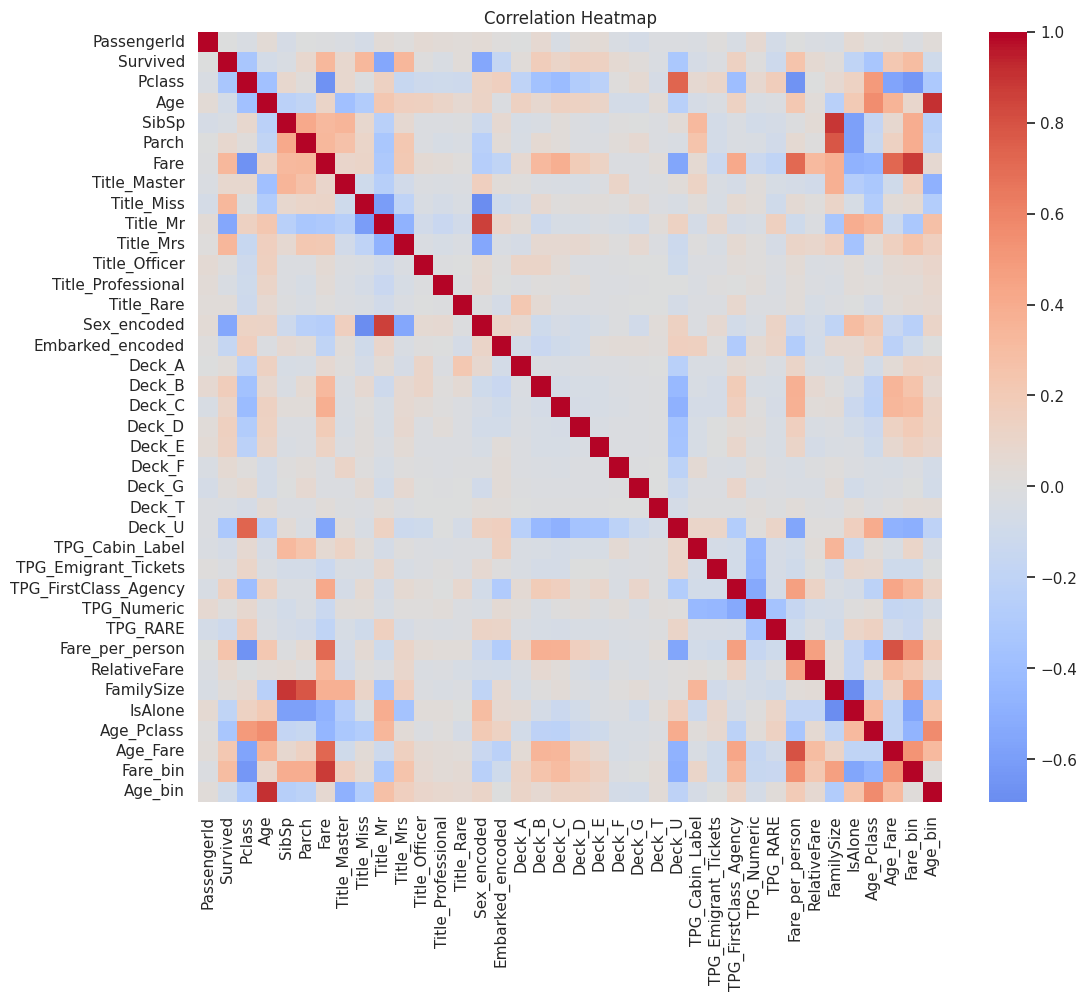

In [67]:
# Heatmap des corrélations numériques
plt.figure(figsize=(12,10))
sns.heatmap(train_df.corr(numeric_only=True), annot=False, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.show()

## Feature importance

In [68]:
# Sélection des features pertinentes
excluded_cols = ['PassengerId', 'Survived', 'Name', 'Sex', 'Ticket', 'TicketPrefix', 'TicketPrefix_grouped', 'Cabin', 'Embarked', 'Title', 'Title_grouped']
features = [col for col in train_df.columns if col not in excluded_cols]

X = train_df[features]
y = train_df['Survived']

In [69]:
# Entraînement
gb = GradientBoostingClassifier(random_state=42, n_estimators=100)
gb.fit(X, y)

GradientBoostingClassifier(random_state=42)

In [70]:
# Récupération des importances
importances = gb.feature_importances_
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

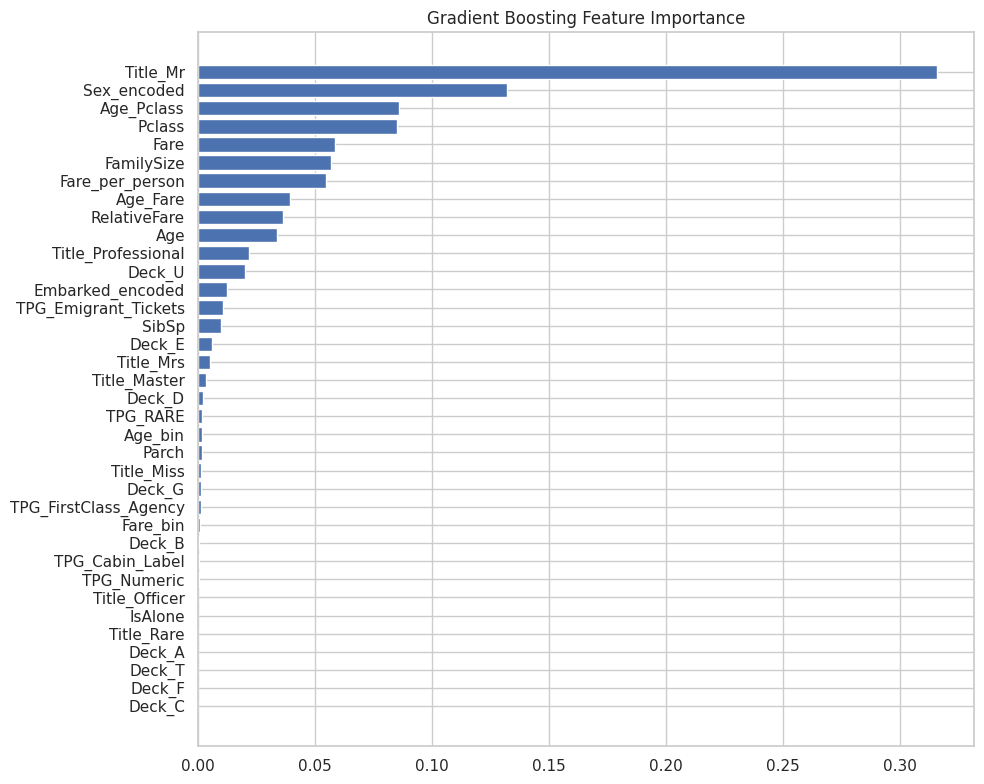

In [71]:
# Visualisation
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.title('Gradient Boosting Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [72]:
# Liste des meilleures features (ex : > moyenne ou top 10)
features_gb_selected = importance_df[importance_df['Importance'] > importance_df['Importance'].mean()]['Feature'].tolist()

In [73]:
# Résultat
print("Nombre de features sélectionnées :", len(features_gb_selected))
print("Features sélectionnées :", features_gb_selected)

Nombre de features sélectionnées : 10
Features sélectionnées : ['Title_Mr', 'Sex_encoded', 'Age_Pclass', 'Pclass', 'Fare', 'FamilySize', 'Fare_per_person', 'Age_Fare', 'RelativeFare', 'Age']


### Stat analysis

In [74]:
# Liste de toutes les colonnes numériques ou one-hot
all_features = [
    col for col in train_df.columns
    if col not in ['Survived', 'PassengerId', 'Name', 'Ticket', 'Cabin']
    and (train_df[col].dtype in ['int64', 'float64'] or col.startswith(('Title_', 'Deck_', 'TPG_')))
]

results = []

for col in all_features:
    try:
        if train_df[col].nunique() > 2 and train_df[col].dtype in ['float64', 'int64']:
            # Test point-biserial (corrélation num vs binaire)
            corr, p = pointbiserialr(train_df[col], train_df['Survived'])
            test_type = 'point-biserial'
        else:
            # Test du χ² pour variable catégorielle (one-hot incluse)
            contingency = pd.crosstab(train_df[col], train_df['Survived'])
            chi2, p, _, _ = chi2_contingency(contingency)
            test_type = 'chi2'

        results.append({
            'Feature': col,
            'Test': test_type,
            'p-value': round(p, 6),
            'Significant': '✅' if p < 0.05 else '❌'
        })
    except Exception as e:
        results.append({
            'Feature': col,
            'Test': 'error',
            'p-value': None,
            'Significant': f'⚠️ {e}'
        })

In [75]:
# Affichage sous forme de DataFrame
stats_df = pd.DataFrame(results).sort_values(by='p-value', na_position='last')
stats_df

,Feature,Test,p-value,Significant
0,Pclass,point-biserial,0.000000,✅
34,Age_Fare,point-biserial,0.000000,✅
33,Age_Pclass,point-biserial,0.000000,✅
32,IsAlone,chi2,0.000000,✅
4,Fare,point-biserial,0.000000,✅
5,Title_grouped,chi2,0.000000,✅
29,Fare_per_person,point-biserial,0.000000,✅
7,Title_Miss,chi2,0.000000,✅
8,Title_Mr,chi2,0.000000,✅
9,Title_Mrs,chi2,0.000000,✅


In [76]:
features_stats = [
    'Pclass', 'Title_Miss',
    'Fare',
    'Sex_encoded', 'Embarked_encoded',
    'Title_Mrs', 'Title_Mr', 'Deck_U',
    'Fare_per_person', 'Deck_B', 'IsAlone',
    'Fare_bin',
    'Age_Pclass', 'Age_Fare', 'Deck_D',
    'TPG_FirstClass_Agency', 'Deck_E', 'Deck_C',
    'TPG_RARE', 'Parch', 'Title_Master', 'Age'
]

In [77]:
train_df[features_stats].head()

,Pclass,Title_Miss,Fare,Sex_encoded,Embarked_encoded,Title_Mrs,Title_Mr,Deck_U,Fare_per_person,Deck_B,IsAlone,Fare_bin,Age_Pclass,Age_Fare,Deck_D,TPG_FirstClass_Agency,Deck_E,Deck_C,TPG_RARE,Parch,Title_Master,Age
0,3,False,-0.879741,1,2,False,True,True,-0.496976,False,0,0,0.027959,-0.480457,False,False,False,False,True,-0.473674,False,-0.592653
1,1,False,1.361220,0,0,True,False,False,2.522573,False,0,3,-0.814330,0.923536,False,True,False,True,False,-0.473674,False,0.590229
2,3,True,-0.798540,0,2,False,False,True,-0.465145,False,1,1,0.388940,-0.454819,False,False,False,False,False,-0.473674,False,-0.296932
3,1,False,1.062038,0,2,True,False,False,0.413134,False,0,3,-0.904575,0.455258,False,False,False,True,False,-0.473674,False,0.368438
4,3,False,-0.784179,1,2,False,True,True,-0.459251,False,1,1,1.201147,-0.413128,False,False,False,False,False,-0.473674,False,0.368438


### Compare and select

In [78]:
features_validated = [
    'Title_Mr',
    'Sex_encoded',
    'Age_Pclass',
    'Pclass',
    'Fare',
    'Age_Fare',
    'Age',
    'Fare_per_person',
    'RelativeFare',
    'Title_Mrs',
    'Title_Miss',
    'Embarked_encoded',
    'Deck_U',
    'FamilySize',
    'SibSp',
    'Parch',
    'Title_Rare',
    'Deck_B',
    'Deck_D',
    'TPG_FirstClass_Agency',
    'Deck_E',
    'Deck_C',
    'TPG_RARE',
    'Title_Professional',
]

In [79]:
X_xgb = train_df[features_gb_selected]
X_stats = train_df[features_stats]
X_valid = train_df[features_validated]

y = train_df['Survived']

In [80]:
# sur xgb features selection
X_train_xgb, X_val_xgb, y_train_xgb, y_val_xgb = train_test_split(
    X_xgb, y, test_size=0.2, random_state=42, stratify=y
)

In [81]:
# sur stat features selection
X_train_stats, X_val_stats, y_train_stats, y_val_stats = train_test_split(
    X_stats, y, test_size=0.2, random_state=42, stratify=y
)

In [82]:
# sur validated features selection
X_train_valid, X_val_valid, y_train_valid, y_val_valid = train_test_split(
    X_valid, y, test_size=0.2, random_state=42, stratify=y
)

In [83]:
# Comparaison avec XGBoost
for X, name in zip([X_xgb, X_stats, X_valid], ['XGB', 'Stats', 'Validated']):
    model = XGBClassifier(random_state=42, n_estimators=100, eval_metric='logloss')
    scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    print(f'{name} set | Accuracy: {scores.mean():.4f} ± {scores.std():.4f}')

XGB set | Accuracy: 0.8126 ± 0.0179
Stats set | Accuracy: 0.8115 ± 0.0323
Validated set | Accuracy: 0.8137 ± 0.0332


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


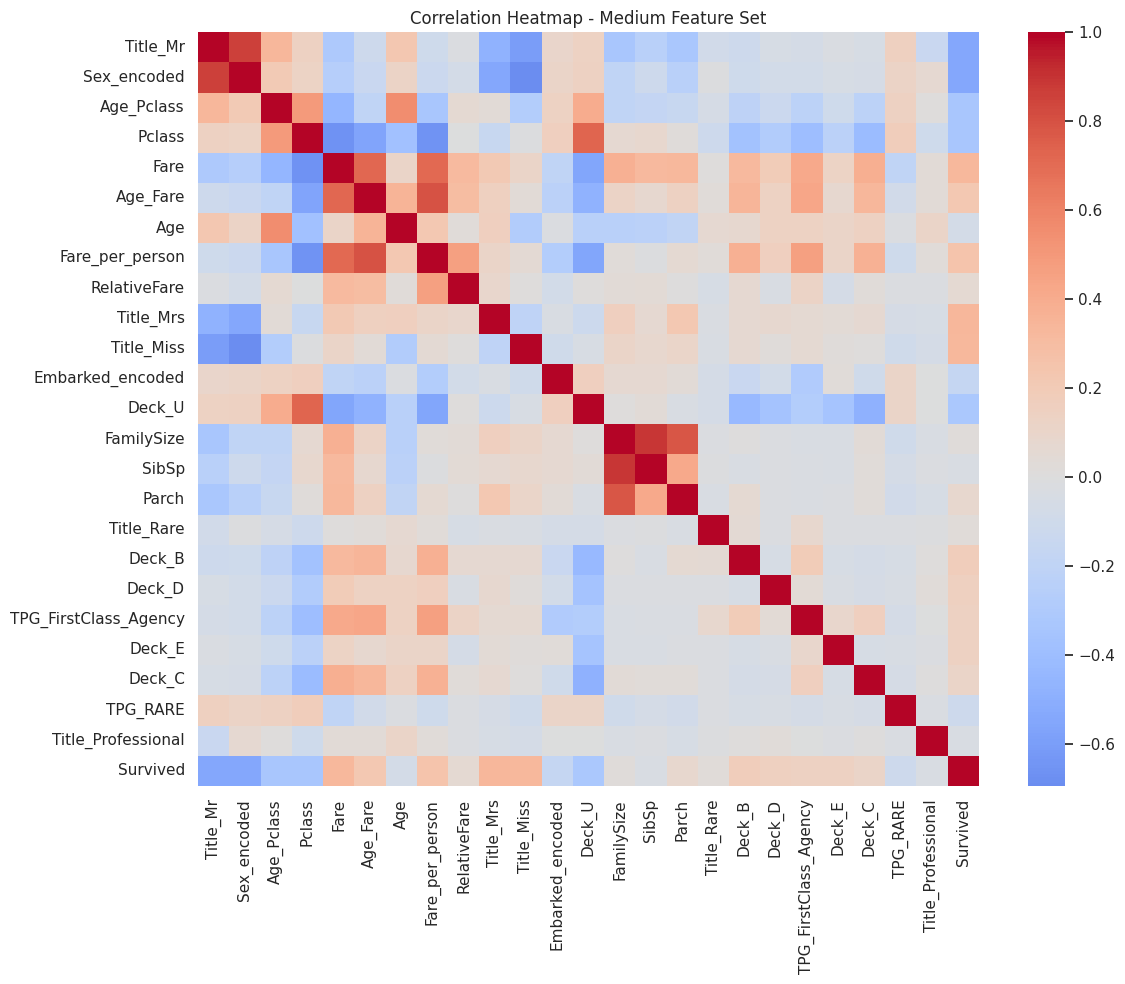

In [84]:
# Corrélations restantes
features_corr = features_validated + ['Survived']
# Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(train_df[features_corr].corr(), annot=False, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap - Medium Feature Set')
plt.tight_layout()
plt.show()

# Model Building

## Split train/validation sets

On part sur le selected features selection, donc :

In [85]:
X_train_valid.head(5)

,Title_Mr,Sex_encoded,Age_Pclass,Pclass,Fare,Age_Fare,Age,Fare_per_person,RelativeFare,Title_Mrs,Title_Miss,Embarked_encoded,Deck_U,FamilySize,SibSp,Parch,Title_Rare,Deck_B,Deck_D,TPG_FirstClass_Agency,Deck_E,Deck_C,TPG_RARE,Title_Professional
692,True,1,0.731872,3,1.124896,0.358919,-0.015998,-0.458269,-0.006278,False,False,2,True,-0.560975,-0.474545,-0.473674,False,False,False,False,False,False,False,False
481,True,1,0.076090,2,-3.058578,-0.568300,0.279722,-0.838856,-2.358701,False,False,2,True,-0.560975,-0.474545,-0.473674,False,False,False,False,False,False,False,False
527,True,1,-1.030919,1,2.523412,3.193722,0.057932,9.619345,5.874529,False,False,2,False,-0.560975,-0.474545,-0.473674,False,False,False,True,False,True,False,False
855,False,0,-0.333022,3,-0.645593,-0.475610,-0.888373,-0.397948,0.528063,True,False,2,True,0.059160,-0.474545,0.767630,False,False,False,False,False,False,False,False
801,False,0,-0.092368,2,0.353956,-0.120132,0.072718,-0.426242,-0.809556,True,False,2,True,0.679295,0.432793,0.767630,False,False,False,False,False,False,False,False


In [86]:
X_train = X_train_valid
X_val = X_val_valid
y_train = y_train_valid
y_val = y_val_valid

## Baseline model (Logistic Regression)

In [87]:
logreg = LogisticRegression(random_state=42, max_iter=1000)
logreg.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [88]:
y_pred = logreg.predict(X_val)

In [89]:
print(f"Accuracy  : {accuracy_score(y_val, y_pred):.4f}")
print(f"Precision : {precision_score(y_val, y_pred):.4f}")
print(f"Recall    : {recall_score(y_val, y_pred):.4f}")
print(f"F1 Score  : {f1_score(y_val, y_pred):.4f}")

Accuracy  : 0.8045
Precision : 0.7656
Recall    : 0.7101
F1 Score  : 0.7368


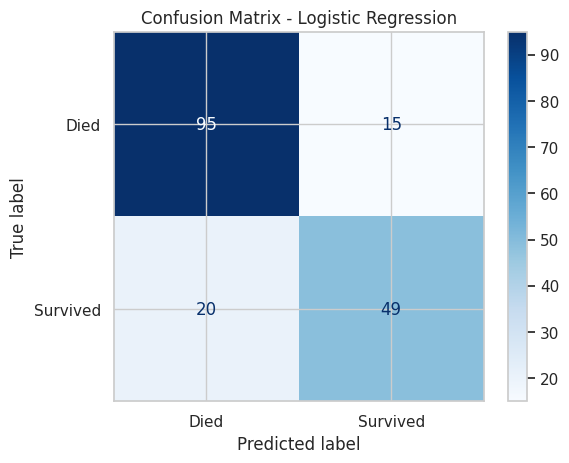

In [90]:
cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Died', 'Survived'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

In [91]:
coefficients = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': logreg.coef_[0]
})
coefficients['Abs_Coefficient'] = coefficients['Coefficient'].abs()
coefficients = coefficients.sort_values(by='Abs_Coefficient', ascending=False)
print("\nTop coefficients:")
print(coefficients[['Feature', 'Coefficient']])


Top coefficients:
                  Feature  Coefficient
0                Title_Mr    -1.980162
23     Title_Professional    -1.024065
20                 Deck_E     0.895984
1             Sex_encoded    -0.788722
18                 Deck_D     0.777962
12                 Deck_U    -0.690455
3                  Pclass    -0.662373
9               Title_Mrs     0.598227
19  TPG_FirstClass_Agency    -0.575296
6                     Age    -0.528186
4                    Fare     0.514295
7         Fare_per_person    -0.429734
14                  SibSp    -0.350012
16             Title_Rare    -0.347889
13             FamilySize    -0.317435
11       Embarked_encoded    -0.265444
5                Age_Fare     0.251972
8            RelativeFare     0.157394
15                  Parch    -0.156559
22               TPG_RARE    -0.154182
10             Title_Miss    -0.135839
21                 Deck_C    -0.091859
17                 Deck_B    -0.059771
2              Age_Pclass    -0.024374


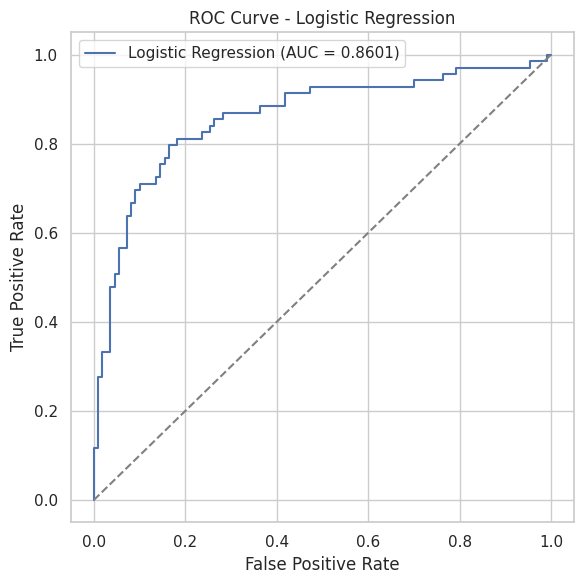

In [92]:
# Prédictions probabilistes
y_proba = logreg.predict_proba(X_val)[:, 1]

# ROC
fpr, tpr, thresholds = roc_curve(y_val, y_proba)
auc_score = roc_auc_score(y_val, y_proba)

# Plot
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"Logistic Regression (AUC = {auc_score:.4f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Other models (Random Forest, SVM, XGBoost, etc.)

In [93]:
# Modèles à tester
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(eval_metric='logloss', random_state=42),
    'SVC': SVC(probability=True, random_state=42)
}

In [94]:
# Évaluation
results = []

for name, model in models.items():
    print(f"\n📦 Training {name}...")
    start = time.time()
    model.fit(X_train, y_train)
    end = time.time()

    y_pred = model.predict(X_val)
    y_proba = model.predict_proba(X_val)[:, 1]

    results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_val, y_pred),
        'Precision': precision_score(y_val, y_pred),
        'Recall': recall_score(y_val, y_pred),
        'F1': f1_score(y_val, y_pred),
        'AUC': roc_auc_score(y_val, y_proba),
        'Training Time (s)': round(end - start, 2)
    })


📦 Training LogisticRegression...

📦 Training RandomForest...

📦 Training GradientBoosting...

📦 Training XGBoost...

📦 Training SVC...


In [95]:
# Affichage résultats
results_df = pd.DataFrame(results).sort_values(by='Accuracy', ascending=False)
display(results_df)

,Model,Accuracy,Precision,Recall,F1,AUC,Training Time (s)
4,SVC,0.832402,0.800000,0.753623,0.776119,0.842688,0.09
2,GradientBoosting,0.810056,0.777778,0.710145,0.742424,0.859354,0.20
0,LogisticRegression,0.804469,0.765625,0.710145,0.736842,0.860079,0.03
3,XGBoost,0.793296,0.728571,0.739130,0.733813,0.846179,0.17
1,RandomForest,0.787709,0.746032,0.681159,0.712121,0.853030,0.23


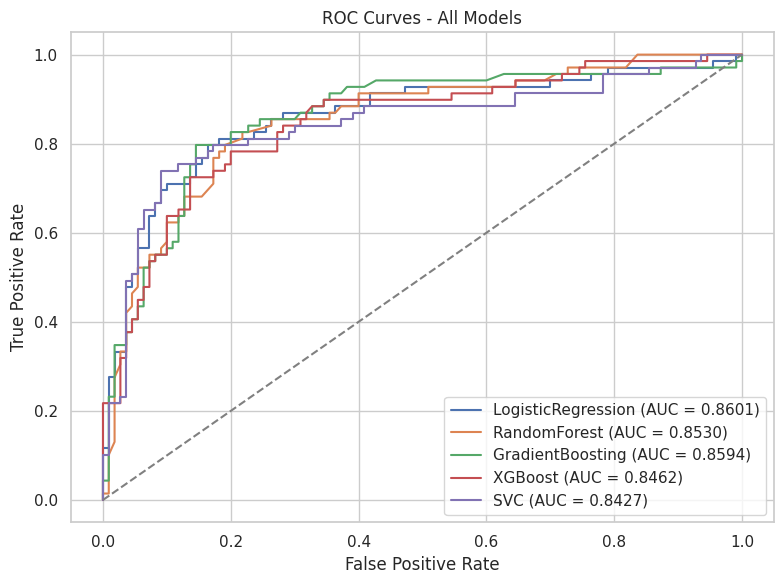

In [96]:
# Couleurs auto
plt.figure(figsize=(8, 6))

for name, model in models.items():
    # Prédictions probabilistes
    y_proba = model.predict_proba(X_val)[:, 1]
    fpr, tpr, _ = roc_curve(y_val, y_proba)
    auc = roc_auc_score(y_val, y_proba)

    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.4f})')

# Diagonale random
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

# Graph setup
plt.title('ROC Curves - All Models')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

# Model Evaluation

## Cross-validation

In [97]:
# Modèles à comparer
models = {
    'SVC': SVC(probability=True, random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    #'XGBoost': XGBClassifier(eval_metric='logloss', random_state=42)
}

In [98]:
# Données
X = X_valid

In [99]:
# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

## Confusion matrix

In [100]:
# Évaluation
for name, model in models.items():
    print(f"\n{name}")

    # Prédictions sur toutes les folds
    y_pred = cross_val_predict(model, X, y, cv=cv)

    # Pour AUC, il faut les probabilités :
    y_proba = cross_val_predict(model, X, y, cv=cv, method='predict_proba')[:, 1]

    # Scores
    acc = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    auc = roc_auc_score(y, y_proba)

    print(f"Accuracy : {acc:.4f}")
    print(f"F1 Score : {f1:.4f}")
    print(f"AUC      : {auc:.4f}")

    # Confusion matrix
    #cm = confusion_matrix(y, y_pred)
    #disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Died', 'Survived'])
    #disp.plot(cmap='Blues')
    #plt.title(f"Confusion Matrix - {name}")
    #plt.tight_layout()
    #plt.show()


SVC
Accuracy : 0.8283
F1 Score : 0.7657
AUC      : 0.8463

GradientBoosting
Accuracy : 0.8451
F1 Score : 0.7850
AUC      : 0.8784


# Hyperparameter Tuning

## GridSearchCV / RandomizedSearchCV

In [101]:
# Définition du modèle de base
gb = GradientBoostingClassifier(random_state=42)

# Grille des hyperparamètres
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'subsample': [0.6, 0.8, 1.0],
    'min_samples_split': [2, 5, 10],
}

In [102]:
# GridSearch avec AUC comme scoring principal
grid_search = GridSearchCV(
    estimator=gb,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    verbose=2
)

# Entraînement
grid_search.fit(X, y)

Fitting 5 folds for each of 162 candidates, totalling 810 fits


GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 4, 5],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200],
                         'subsample': [0.6, 0.8, 1.0]},
             scoring='accuracy', verbose=2)

In [103]:
# Résultat
print("Best parameters found:")
print(grid_search.best_params_)

print(f"Best accuracy score: {grid_search.best_score_:.4f}")

Best parameters found:
{'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 200, 'subsample': 0.8}
Best accuracy score: 0.8462


## Best model selection

In [104]:
best_model = grid_search.best_estimator_

# Final Model & Prediction

## Train on full training data

In [105]:
X_final = train_df[features_validated]
y_final = train_df['Survived']

X_test_final = test_df[features_validated]

In [106]:
best_model.fit(X_final, y_final)

GradientBoostingClassifier(min_samples_split=5, n_estimators=200,
                           random_state=42, subsample=0.8)

## Predict on test set

In [107]:
y_test_pred = best_model.predict(X_test_final)

## Submission file generation

In [108]:
# Création du fichier de soumission
submission = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Survived': y_test_pred
})

submission.to_csv('submission.csv', index=False)
print("✅ Submission file saved: submission.csv")

✅ Submission file saved: submission.csv
